# 機械学習を用いた異常検知入門

本章では、機械学習を用いて異常検知を行う方法について触れます。  
前提として今回触れているのは時系列データではないテーブルデータに適用するパターンを想定しています。  

ここでは以下の 3 つをご紹介します。  

1. k-Nearest Neighbors
2. OneClassSVM
3. Isolation Forest

## k-Nearest Neighbors  
こちらは、異常検知の手法として K- 近傍法を用いる方法です。  

k- 近傍法には、教師あり学習と教師なし学習があります。

- NearestNeighbors
- KNeighborsClassifier
- KNeighborsRegressor

異常検知に使用する場合には、教師なし学習の `NearestNeighbors` を使用します。新しく入ってきたデータ(判別したいデータ)との距離が近いデータ k 個の中で異常データの割合から異常度を計算し、閾値を超えたら異常と判定するという手法です。  

![06](img/04/06.png)

**メリット**  
1. データの分布に関する前提条件がいらない
2. 正常データが複数箇所でまとまっていても使用できる
3. 異常度の計算が簡単のため、実装が容易  

**デメリット**  
1. データの前提条件がないため、閾値が数式で求まらない
2. ハイパーパラメータ k の設定が難しい
3. 怠惰学習（※1）のため、新しいデータを分類するための計算量が毎回多い

サンプル数が多ければ多いほど推論フェーズでの計算時間が長くなるモデルです。そのため、目安としてサンプルデータ数が100,000以上、次元数10以上のデータの場合には計算量が増えてしまうため適さ無いとされています。  

＊怠惰学習：単純に教師データを丸暗記するタイプの学習アルゴリズム。計算しないでデータを取り込むのみ。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [37]:
# データの準備
np.random.seed(0)
x1 = np.random.normal(0, 1, 1000)
x2 = x1 + np.random.normal(0, 0.3, 1000)
normal = np.stack([x1, x2], axis=1)
anomaly = np.array([[-4, -5], [-1.5, 2], [2.5, -2.5]])
data = np.concatenate([normal, anomaly], axis=0)

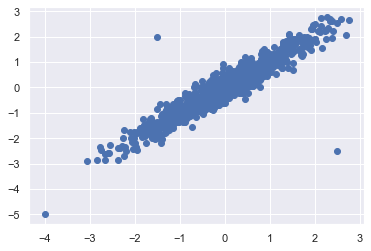

In [20]:
plt.scatter(data[:, 0], data[:, 1])

それでは実装しましょう。   　　　


**【実装の流れ】**  

- モデルを定義
- 各データの異常度を計算
- 閾値を設定
- 閾値と異常度で異常判定

In [21]:
from sklearn.neighbors import NearestNeighbors

In [22]:
nbrs = NearestNeighbors(n_neighbors=2)
nbrs.fit(data)

NearestNeighbors(n_neighbors=2)

検知を行うためには、実際のそれぞれのデータの距離の情報が必要です。`kneighbors` メソッドで算出できるので算出します。  

In [23]:
# 距離と近傍点
distances, indices = nbrs.kneighbors(data)

In [24]:
# 距離
distances

array([[0.        , 0.06539206],
       [0.        , 0.01313276],
       [0.        , 0.03627436],
       ...,
       [0.        , 2.32587152],
       [0.        , 1.82371576],
       [0.        , 2.90030391]])

In [25]:
# 近傍点
indices

array([[   0,  742],
       [   1,  531],
       [   2,  145],
       ...,
       [1000,  589],
       [1001,   54],
       [1002,  446]])

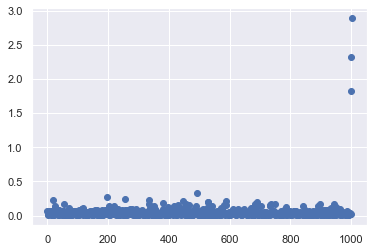

In [26]:
plt.scatter(range(len(distances)), distances[:, 1])

異常なものだけが、検出できていることがわかります。  
可視化して見やすくするためにデータフレームに格納した後、anomaly_score が一定を超えているデータをあぶり出し可視化します。   

In [34]:
kn_data = pd.DataFrame(data, columns=['x1', 'x2'])
kn_data['anomaly_score'] = distances[:, 1]
kn_data

,x1,x2,anomaly_score
0,1.764052,1.930841,0.065392
1,0.400157,0.667899,0.013133
2,0.978738,0.852044,0.036274
3,2.240893,2.272307,0.028188
4,1.867558,1.935974,0.060462
...,...,...,...
998,-1.147611,-1.490181,0.034806
999,-0.358114,-0.751405,0.019717
1000,-4.000000,-5.000000,2.325872
1001,-1.500000,2.000000,1.823716


In [28]:
# 正常データの割合（1 - 異常発生率）
1 - (3 / 1003)

0.9970089730807578

正常データの割合は約 99.8% であることがわかりました。つまり、ですので、データの約 99.8% が踏まれる分位点を取得すればそれをこえるものは異常であることがわかります。   

In [29]:
# 閾値設定(0.2%分位点)
threshold = np.percentile(distances[:, 1], 99.8)
threshold

1.8177330404611793

In [35]:
kn_data['pred'] = kn_data['anomaly_score'].map(lambda x: 1 if x>threshold else 0)
kn_data

,x1,x2,anomaly_score,pred
0,1.764052,1.930841,0.065392,0
1,0.400157,0.667899,0.013133,0
2,0.978738,0.852044,0.036274,0
3,2.240893,2.272307,0.028188,0
4,1.867558,1.935974,0.060462,0
...,...,...,...,...
998,-1.147611,-1.490181,0.034806,0
999,-0.358114,-0.751405,0.019717,0
1000,-4.000000,-5.000000,2.325872,1
1001,-1.500000,2.000000,1.823716,1


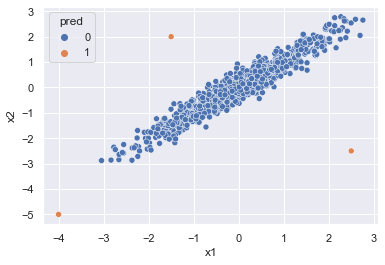

In [36]:
sns.scatterplot(x=kn_data['x1'], y=kn_data['x2'], hue=kn_data['pred']);

## OneClassSVM  

クラス分類問題に用いられるSVMは教師あり学習ですが、OneClassSVMは教師なし学習です。したがって、外れ値検出のための教師データは不要です。

正常データとして1つのクラスを学習させ、識別境界を決定することで、その境界を基準として外れ値を検出します。異常がほとんど発生せず、異常クラスのデータを集めにくいようなシステムで異常検知を実現したい場合には有効な外れ値検知手法です。

OneClassSVMでは、全ての学習データをクラスタ1とし、原点のみをクラスタ-1に属するようにカーネルトリックを用いて、高次元空間の特徴空間へデータを写像します。このとき、学習データは原点から遠くに配置されるように写像されるため、元の学習データと類似していないデータは原点の近くに集まるようになります。この性質を用いて正常および異常データの区別をすることができます。  



それでは実装を行います。`sklearn.svm` の `OneClassSVM` モジュールによって実装可能です。モデルを定義し、データの異常度を計算します。ハイパーパラメータ として、

1. kernel
2. gamma
3. nu

を設定する必要があります。`kernel` とはどのように空間を歪めるかを意味し、基本は孤立した点とまとまった点を分けるように `rbf` を使用します。`gamma` は `rbf` のパラメータですが、sklearnのモジュールを使う際には `auto` と指定すると最適化されます。`nu` は異常データの割合を示しています。  

なおデータは先程用いたデータを再度利用します。   

In [32]:
# 正常データのみを学習させる
from sklearn.svm import OneClassSVM
# 異常データの発生率は 1% とする（仮）
clf = OneClassSVM(kernel='rbf', gamma='auto', nu=.01)
clf.fit(normal)

OneClassSVM(gamma='auto', nu=0.01)

In [39]:
# 異常度算出
anomaly_scores = clf.decision_function(data)
anomaly_scores

array([ 0.18909216,  0.27661899,  0.25456026, ..., -1.96315875,
       -1.79306457, -2.04213086])

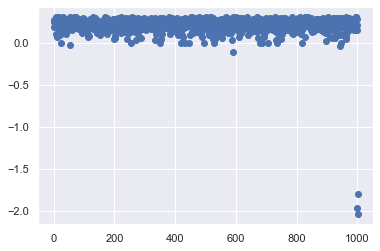

In [40]:
plt.scatter(range(len(anomaly_scores)), anomaly_scores)

In [41]:
oc_data = pd.DataFrame(data, columns=['x1', 'x2'])
oc_data['anomaly_score'] = anomaly_scores
oc_data

,x1,x2,anomaly_score
0,1.764052,1.930841,0.189092
1,0.400157,0.667899,0.276619
2,0.978738,0.852044,0.254560
3,2.240893,2.272307,0.229557
4,1.867558,1.935974,0.208642
...,...,...,...
998,-1.147611,-1.490181,0.211222
999,-0.358114,-0.751405,0.150618
1000,-4.000000,-5.000000,-1.963159
1001,-1.500000,2.000000,-1.793065


In [42]:
# 異常発生率
3 / 1003

0.0029910269192422734

In [ ]:
# 閾値設定(0.2%分位点)
threshold = np.percentile(anomaly_scores, .2)
threshold

In [43]:
# 異常判定
oc_data['pred'] = oc_data['anomaly_score'].map(lambda x: 1 if x<threshold else 0)
oc_data

,x1,x2,anomaly_score,pred
0,1.764052,1.930841,0.189092,1
1,0.400157,0.667899,0.276619,1
2,0.978738,0.852044,0.254560,1
3,2.240893,2.272307,0.229557,1
4,1.867558,1.935974,0.208642,1
...,...,...,...,...
998,-1.147611,-1.490181,0.211222,1
999,-0.358114,-0.751405,0.150618,1
1000,-4.000000,-5.000000,-1.963159,1
1001,-1.500000,2.000000,-1.793065,1


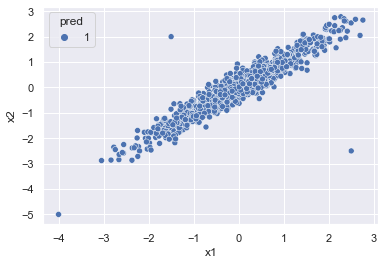

In [44]:
sns.scatterplot(x=oc_data['x1'], y=oc_data['x2'], hue=oc_data['pred']);

## Isolation Forest

Isolation Forest はアンサンブルの決定木に属するクラスタリングアルゴリズムです。

分類木に基づいており、多変量のデータにも対応できます。  
結果が -1 であれば外れ値であることを意味します。

![05](img/04/05.png)

In [53]:
from sklearn.ensemble import IsolationForest
# 関数
def iforest_outliers(x):
    iforest = IsolationForest()
    preds = iforest.fit_predict(x)
    return preds, iforest

In [54]:
preds, model = iforest_outliers(data)
preds

array([-1,  1,  1, ..., -1, -1, -1])

In [55]:
np.unique(preds, return_counts=True)

(array([-1,  1]), array([189, 814]))

In [56]:
is_data = pd.DataFrame(data, columns=['x1', 'x2'])
is_data['pred'] = preds

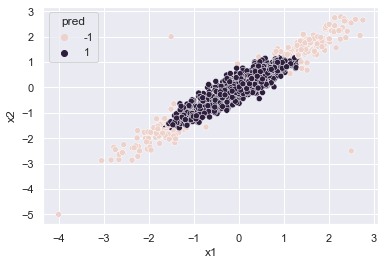

In [57]:
sns.scatterplot(x=is_data['x1'], y=is_data['x2'], hue=is_data['pred']);

[Text(1088.1000000000001, 391.392, 'x2 <= 1.46\nsquared_error = 0.08\nsamples = 256\nvalue = 0.47'),
 Text(669.6, 304.416, 'x1 <= -0.57\nsquared_error = 0.08\nsamples = 244\nvalue = 0.46'),
 Text(334.8, 217.44, 'x1 <= -1.45\nsquared_error = 0.09\nsamples = 79\nvalue = 0.46'),
 Text(167.4, 130.464, 'x1 <= -3.02\nsquared_error = 0.06\nsamples = 18\nvalue = 0.42'),
 Text(83.7, 43.488, '\n  (...)  \n'),
 Text(251.10000000000002, 43.488, '\n  (...)  \n'),
 Text(502.20000000000005, 130.464, 'x2 <= -1.74\nsquared_error = 0.09\nsamples = 61\nvalue = 0.47'),
 Text(418.5, 43.488, '\n  (...)  \n'),
 Text(585.9, 43.488, '\n  (...)  \n'),
 Text(1004.4000000000001, 217.44, 'x1 <= -0.2\nsquared_error = 0.08\nsamples = 165\nvalue = 0.46'),
 Text(837.0, 130.464, 'x1 <= -0.48\nsquared_error = 0.1\nsamples = 43\nvalue = 0.48'),
 Text(753.3000000000001, 43.488, '\n  (...)  \n'),
 Text(920.7, 43.488, '\n  (...)  \n'),
 Text(1171.8, 130.464, 'x2 <= -0.35\nsquared_error = 0.07\nsamples = 122\nvalue = 0.46'),

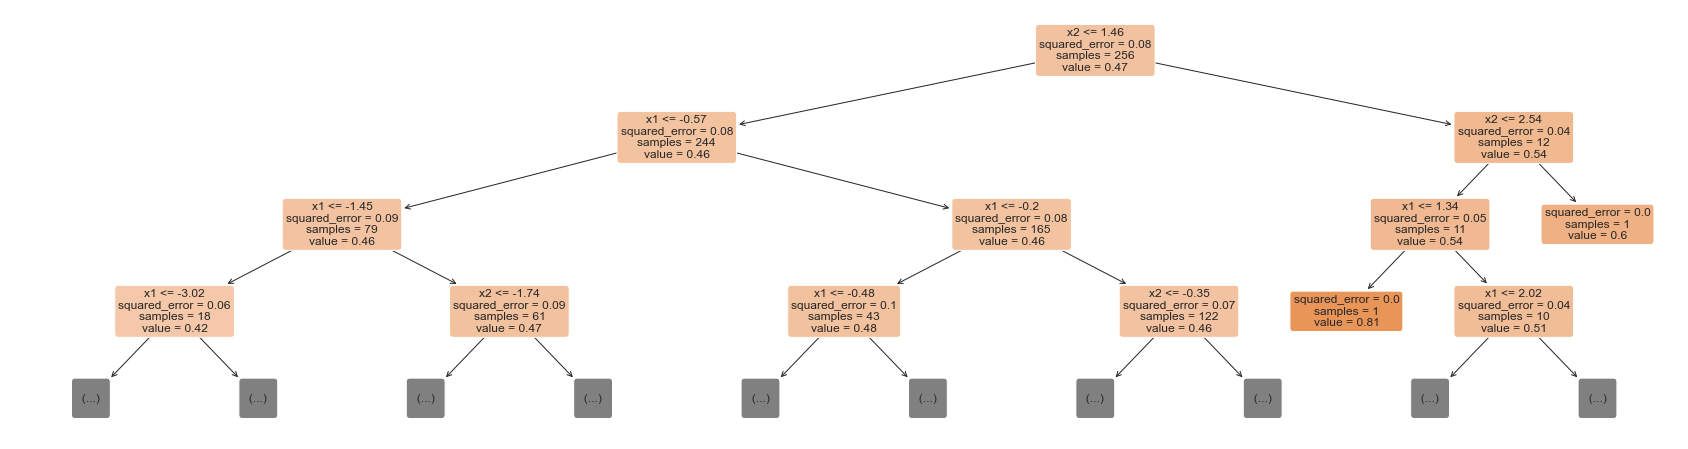

In [60]:
from sklearn.tree import plot_tree

estimator = model.estimators_[0]
 
# 図のサイズ設定
plt.figure(figsize=(30, 8))
# plt.figure(figsize=(30, 8), dpi=100)
 
# 決定木の可視化
plot_tree(
        estimator,
        max_depth=3,
        feature_names = is_data.columns[:2],
        # proportion=True,
        filled=True,
        rounded=True,
        precision=2,
        fontsize=12,
    )